# Fitting the Brick 23 IR CMD (V2)

In [9]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# %config InlineBackend.figure_format='svg'

import os
import time
from glob import glob
import numpy as np

brick = 23
STARFISH = os.getenv("STARFISH")
isoc_dir = "b23ir2_isoc"
lib_dir = "b23ir2_lib"
synth_dir = "b23ir2_synth"
fit_dir = "b23ir2_fit"
wfc3_bands = ['F110W', 'F160W']

## Download Isochrones

Isochrones are distributed in a linear grid of 0.5 Gyr thereafter between 0.5 Gyr and 13 Gyr. We use a range of five metallicities centered on solar ($z=0.019$).

In [10]:
from astropy.coordinates import Distance
import astropy.units as u

from padova import AgeGridRequest, IsochroneRequest
from starfisher import LibraryBuilder

z_grid = [0.012, 0.015, 0.019, 0.024, 0.03]
delta_gyr = 0.5
late_ages = np.log10(np.arange(0.5 * 1e9 + delta_gyr, 13e9, delta_gyr * 1e9))
print late_ages
if not os.path.exists(os.path.join(STARFISH, isoc_dir)):
    for z in z_grid:
        # Old ages in linear grid
        for logage in late_ages:
            r = IsochroneRequest(z, logage,
                                 phot='wfc3', photsys_version='odfnew')
            r.isochrone.export_for_starfish(os.path.join(STARFISH, isoc_dir),
                                     bands=wfc3_bands)

d = Distance(785 * u.kpc)
builder = LibraryBuilder(isoc_dir, lib_dir,
                         nmag=len(wfc3_bands),
                         dmod=d.distmod.value,
                         iverb=3)
if not os.path.exists(builder.full_isofile_path):
    builder.install()

[  8.69897      9.           9.17609126   9.30103      9.39794001
   9.47712125   9.54406804   9.60205999   9.65321251   9.69897      9.74036269
   9.77815125   9.81291336   9.84509804   9.87506126   9.90308999
   9.92941893   9.95424251   9.97772361  10.          10.0211893
  10.04139269  10.06069784  10.07918125  10.09691001]


## Build the Isochrone Library and Synthesize CMD planes

In [11]:
from collections import namedtuple
from starfisher import Lockfile
from starfisher import Synth
from starfisher import ExtinctionDistribution
from starfisher import ExtantCrowdingTable
from starfisher import ColorPlane
from m31hst.phatast import PhatAstTable

if not os.path.exists(os.path.join(STARFISH, synth_dir)):
    os.makedirs(os.path.join(STARFISH, synth_dir))

# No binning in our lockfile
lockfile = Lockfile(builder.read_isofile(), synth_dir, unbinned=True)

# No extinction, yet
young_av = ExtinctionDistribution()
old_av = ExtinctionDistribution()
rel_extinction = np.ones(len(wfc3_bands), dtype=float)
for av in (young_av, old_av):
    av.set_uniform(0.)

# Use PHAT AST from the outer field
crowd_path = os.path.join(synth_dir, "crowding.dat")
full_crowd_path = os.path.join(STARFISH, crowd_path)
tbl = PhatAstTable()
tbl.write_crowdfile_for_field(full_crowd_path, 0)
crowd = ExtantCrowdingTable(crowd_path)

# Define CMD planes
Lim = namedtuple('Lim', 'x y')
ir_lim = Lim(x=(0.3, 1.3), y=(24, 16.5))
ir_cmd = ColorPlane((wfc3_bands.index('F110W'),
                     wfc3_bands.index('F160W')),
                    wfc3_bands.index('F160W'),
                    ir_lim.x,
                    (min(ir_lim.y), max(ir_lim.y)),
                    28.,
                    suffix='f110f160',
                    x_label=r'$\mathrm{F110W}-\mathrm{F160W}$',
                    y_label=r'$\mathrm{F110W}$',
                    dpix=0.1)
ir_cmd.mask_region((-1., 0.), (22., 16))
ir_cmd.mask_region((0, 0.3), (22., 16))
ir_cmd.mask_region((0.3, 0.7), (20., 16))
ir_cmd.mask_region((0.7, 0.8), (19., 16))
ir_cmd.mask_region((0.8, 0.9), (18., 16))
ir_cmd.mask_region((1.1, 1.5), (28, 21))
colour_planes = [ir_cmd]

synth = Synth(synth_dir, builder, lockfile, crowd,
              rel_extinction,
              young_extinction=young_av,
              old_extinction=old_av,
              planes=colour_planes,
              mass_span=(0.08, 150.),
              nstars=10000000)
if len(glob(os.path.join(STARFISH, synth_dir, "z*"))) == 0:
    synth.run_synth(n_cpu=4)
# synth.plot_all_hess(os.path.join(STARFISH, synth_dir, 'hess'))

nx 10
ny 75
x.shape (75, 10)


## Export the dataset for StarFISH

In [12]:
from astropy.table import Table
from m31hst import phat_v2_phot_path

if not os.path.exists(os.path.join(STARFISH, fit_dir)):
    os.makedirs(os.path.join(STARFISH, fit_dir))

data_root = os.path.join(fit_dir, "b23ir.")
full_data_path = os.path.join(STARFISH, '{0}f110f160'.format(data_root))
brick_table = Table.read(phat_v2_phot_path(brick), format='fits')

# Only use stars within the fitting box
c = brick_table['f110w_vega'] - brick_table['f160w_vega']
m = brick_table['f160w_vega']
sel = np.where((c > min(ir_lim.x)) & (c < max(ir_lim.x)) &
               (m > min(ir_lim.y)) & (m < max(ir_lim.y)))[0]
brick_table = brick_table[sel]

print("Fitting {0:d} stars".format(len(brick_table)))

if not os.path.exists(full_data_path):
    phot_dtype = np.dtype([('x', np.float), ('y', np.float)])
    photdata = np.empty(len(brick_table), dtype=phot_dtype)
    photdata['x'][:] = brick_table['f110w_vega'] - brick_table['f160w_vega']
    photdata['y'][:] = brick_table['f160w_vega']    
    np.savetxt(full_data_path, photdata, delimiter=' ', fmt='%.4f')

/Users/jsick/phat_data
Fitting 480492 stars


{'origin': 'lower', 'extent': [0.3, 1.3, 24, 16.5], 'vmin': None, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x105691490>, 'aspect': 'auto', 'vmax': None, 'alpha': None, 'norm': None, 'interpolation': 'none'}


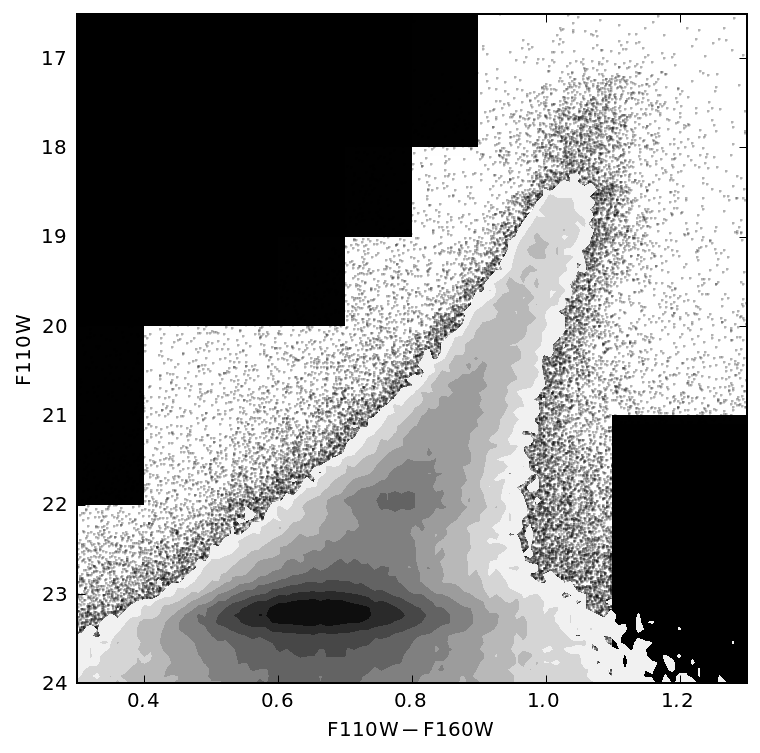

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from androcmd.plot import contour_hess

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
contour_hess(ax, brick_table['f110w_vega'] - brick_table['f160w_vega'],
             brick_table['f160w_vega'], ir_lim.x, (max(ir_lim.y), min(ir_lim.y)),
             plot_args={'ms': 3})
ir_cmd.plot_mask(ax)
# ir_cmd.plot_mask(ax, imshow_args=dict(origin='upper'))
ax.set_xlabel(r'$\mathrm{F110W}-\mathrm{F160W}$')
ax.set_ylabel(r'$\mathrm{F110W}$')
ax.set_xlim(ir_lim.x)
ax.set_ylim(ir_lim.y)
fig.show()

## Run StarFISH SFH

In [14]:
from starfisher import SFH, Mask

print colour_planes
mask = Mask(colour_planes)
sfh = SFH(data_root, synth, mask, fit_dir)
if not os.path.exists(sfh.full_outfile_path):
    sfh.run_sfh()
sfh_table = sfh.solution_table()

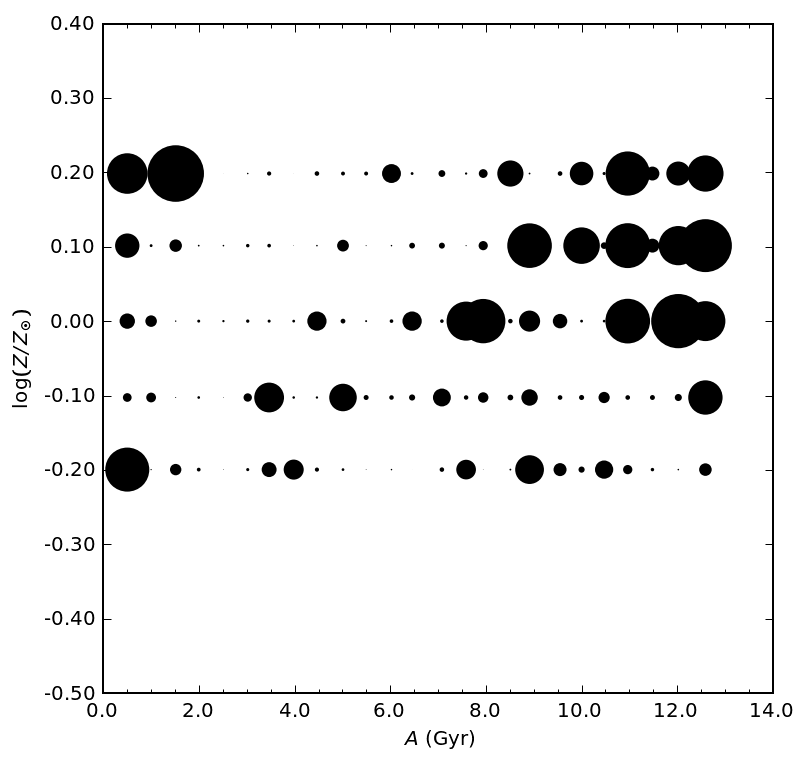

In [15]:
from starfisher.sfhplot import LinearSFHCirclePlot

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
cp = LinearSFHCirclePlot(sfh_table)
cp.plot_in_ax(ax, max_area=800)
ax.set_ylim(-0.5, 0.4)
fig.show()

{'origin': 'lower', 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x10bb99d50>, 'extent': [0.3, 1.3, 24, 16.5], 'aspect': 'auto', 'interpolation': 'none'}
{'origin': 'lower', 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x10bbe7810>, 'extent': [0.3, 1.3, 24, 16.5], 'aspect': 'auto', 'interpolation': 'none'}
{'origin': 'lower', 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x10bbe7a10>, 'extent': [0.3, 1.3, 24, 16.5], 'aspect': 'auto', 'interpolation': 'none'}


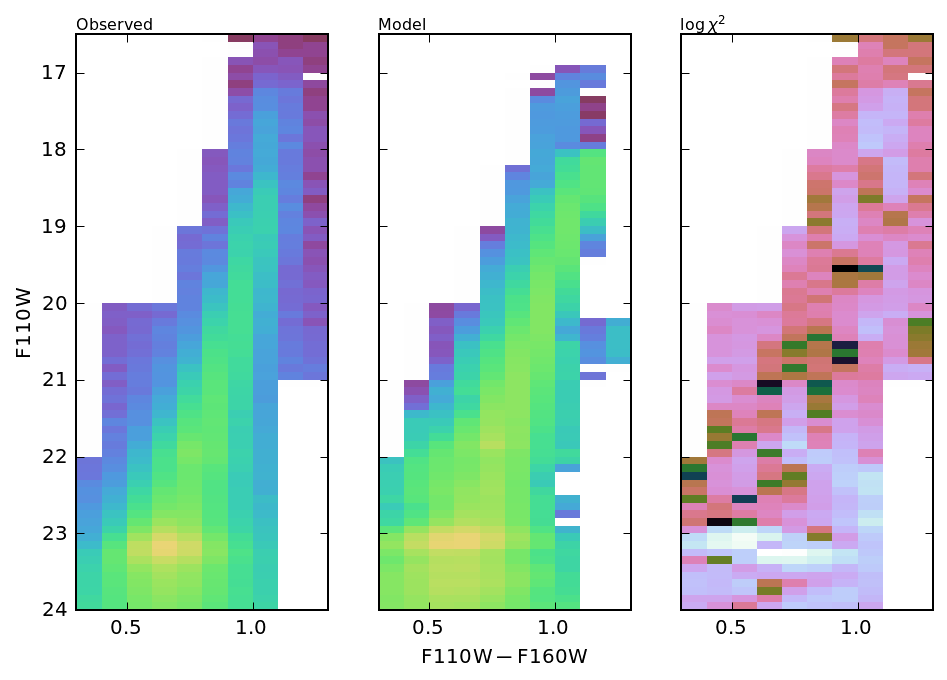

In [16]:
import cubehelix
cmapper = lambda: cubehelix.cmap(startHue=240,endHue=-300,minSat=1,maxSat=2.5,minLight=.3,maxLight=.8,gamma=.9)

from starfisher.sfhplot import ChiTriptykPlot
fig = plt.figure(figsize=(7, 5))
ctp = ChiTriptykPlot(sfh.full_chi_path, 1, ir_cmd.x_span, ir_cmd.y_span,
                     ir_cmd.dpix, ir_cmd.x_label, ir_cmd.y_label,
                    flipy=True)
ax_obs, ax_mod, ax_chi = ctp.setup_axes(fig)
ctp.plot_obs_in_ax(ax_obs, cmap=cmapper())
ctp.plot_mod_in_ax(ax_mod, cmap=cmapper())
ctp.plot_chi_in_ax(ax_chi, cmap=cubehelix.cmap())
ax_obs.text(0.0, 1.01, "Observed", transform=ax_obs.transAxes, size=8, ha='left')
ax_mod.text(0.0, 1.01, "Model", transform=ax_mod.transAxes, size=8, ha='left')
ax_chi.text(0.0, 1.01, r"$\log \chi^2$", transform=ax_chi.transAxes, size=8, ha='left')
fig.show()